In [3]:
!pip install ndlib

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

n = 20
N =374

def plot(aspl, title, xlab, ylab):
    plt.violinplot(aspl, showmeans=True)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)

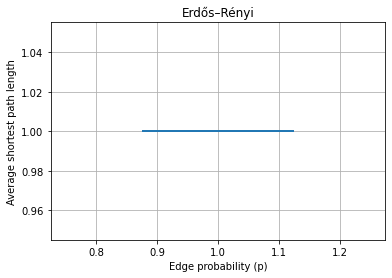

In [9]:
p_values = [0.016, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

aspl_Erdos = []  # list of lists
for p in p_values:
    aspl = []
    for _ in range(n):
        G = nx.erdos_renyi_graph(N, p)
        try:
            aspl.append(nx.average_shortest_path_length(G))
        except:
            continue
    if aspl == []:
        continue
    aspl_Erdos.append(aspl)
plot(aspl_Erdos, "Erdős–Rényi", "Edge probability (p)", "Average shortest path length")
plt.savefig("ASP_ER.png")

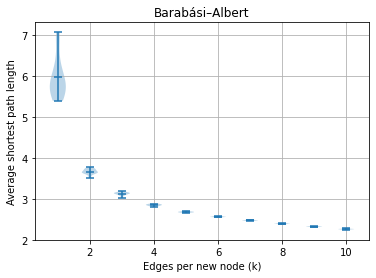

In [7]:
M_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

aspl_BA = []
for m in M_values:
    aspl = []
    for _ in range(n):
        G = nx.barabasi_albert_graph(N, m)
        aspl.append(nx.average_shortest_path_length(G))
    aspl_BA.append(aspl)
plot(aspl_BA, "Barabási–Albert", "Edges per new node (k)", "Average shortest path length")
plt.savefig("ASP_BA.png")

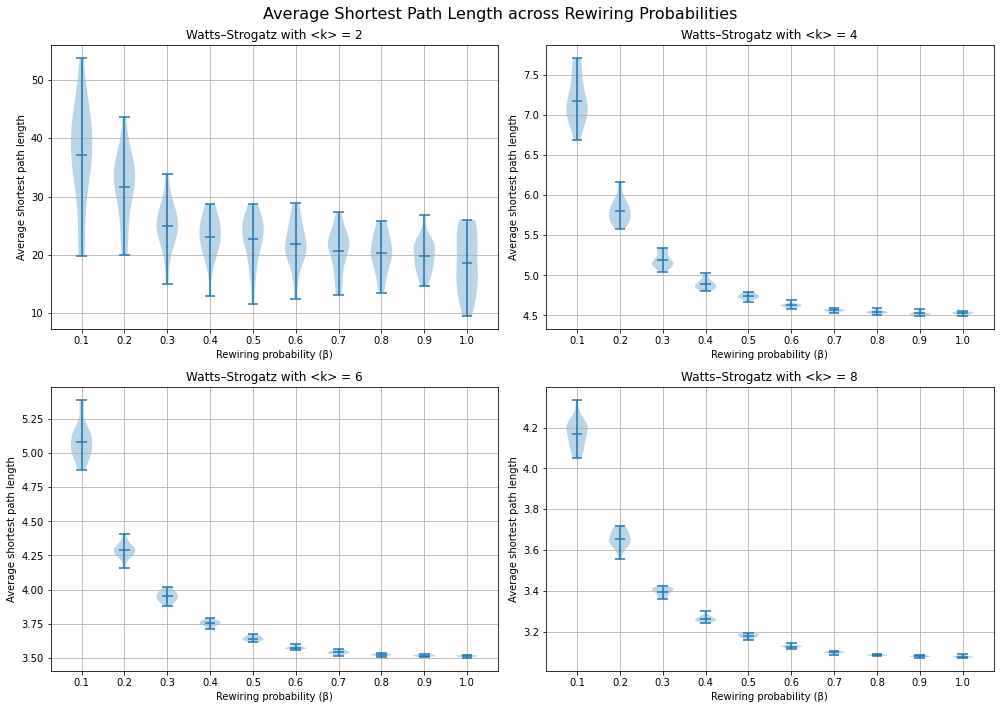

In [8]:
initial_neighbors_list = [2, 4, 6, 8]   # four different <k>
rewiring_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# compute ASPL on largest connected component (avoids errors)
def aspl_on_lcc(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    lcc = max(nx.connected_components(G), key=len)
    H = G.subgraph(lcc).copy()
    return nx.average_shortest_path_length(H)

aspl_data = []

for k in initial_neighbors_list:
    results_for_k = []
    for beta in rewiring_prob:
        vals = []
        for _ in range(n):
            G = nx.watts_strogatz_graph(N, k, beta)
            vals.append(aspl_on_lcc(G))
        results_for_k.append(vals)
    aspl_data.append(results_for_k)

# ---- Plotting: 4 subplots ----

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, k in enumerate(initial_neighbors_list):
    ax = axes[i]
    ax.violinplot(aspl_data[i], showmeans=True, positions=rewiring_prob, widths=0.05)
    ax.set_title(f"Watts–Strogatz with <k> = {k}")
    ax.set_xlabel("Rewiring probability (β)")
    ax.set_ylabel("Average shortest path length")
    ax.set_xticks(rewiring_prob)
    ax.grid(True)

plt.suptitle("Average Shortest Path Length across Rewiring Probabilities", fontsize=16)
plt.tight_layout()
plt.savefig("ASP_WS.png")
plt.show()

In [13]:
import networkx as nx
from ndlib.models.epidemics import SIRModel
from ndlib.models.ModelConfig import Configuration

def avr_degree_to_Erdos(N, k):
    return nx.erdos_renyi_graph(N, max(0.0, min(1.0, k/(N-1))))

def avr_degree_to_WS(N, k, beta):
    if k % 2 != 0:
        k = k+1
    if k >= N:
        k = max(2, N - (N % 2) - 2)
    return nx.watts_strogatz_graph(N, k, beta)

def avr_degree_to_BA(N, k):
    m = int(round(k / 2.0))
    m = max(1, min(m, N - 1))
    return nx.barabasi_albert_graph(N, m)
    
def SIR(G, beta, gamma, fraction_infected, time):
    model = SIRModel(G)
    config = Configuration()
    config.add_model_parameter("beta", float(beta))
    config.add_model_parameter("gamma", float(gamma))

    config.add_model_parameter("percentage_infected", float(fraction_infected))
    model.set_initial_status(config)

    its = model.iteration_bunch(steps)

    S, I, R = [], [], []
    for it in its:
        cnt = it["node_count"]
        S.append(cnt.get(0, 0))
        I.append(cnt.get(1, 0))
        R.append(cnt.get(2, 0))
    return np.array(S), np.array(I), np.array(R)
    

betas = [0.05, 0,2, 0.7]
gamma = 0.02
avg_degrees = [2,4,8,10]

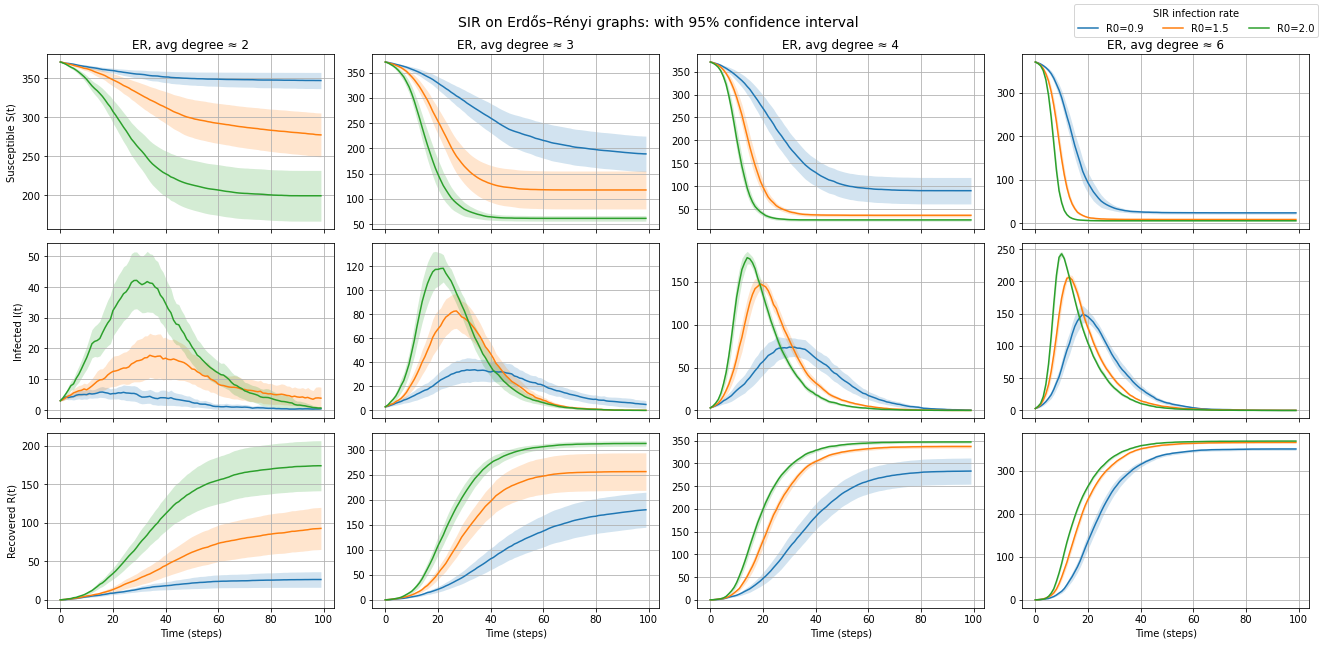

In [14]:
repetitions = 20
N = 374
betas = [0.09, 0.15, 0.2]   # infection rates
gamma = 0.1
avg_degrees = [2, 3, 4 ,6]
fraction_infected = 0.01
steps = 100

# ----------------------
# Simulation + Plotting
# ----------------------
ncols = len(avg_degrees)
fig, axes = plt.subplots(3, ncols, figsize=(4.6*ncols, 9), sharex=True)
metric_names = ["Susceptible S(t)", "Infected I(t)", "Recovered R(t)"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
t = np.arange(steps)

for col, k in enumerate(avg_degrees):
    # Prepare storage: dict beta -> runs matrix (repetitions x steps)
    S_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    I_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    R_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}

    # For fairness: in each repetition, use one ER graph for all betas
    for r in range(repetitions):
        G = avr_degree_to_Erdos(N, k)
        for b in betas:
            S, I, R = SIR(G.copy(), b, gamma, fraction_infected, steps)
            S_runs[b][r, :] = S
            I_runs[b][r, :] = I
            R_runs[b][r, :] = R

    # Plot S(t), I(t), R(t) means with ±1σ bands
    axS, axI, axR = axes[0, col], axes[1, col], axes[2, col]

    for i, b in enumerate(betas):
        c = colors[i % len(colors)]

        S_mean, S_std = S_runs[b].mean(axis=0), S_runs[b].std(axis=0)
        I_mean, I_std = I_runs[b].mean(axis=0), I_runs[b].std(axis=0)
        R_mean, R_std = R_runs[b].mean(axis=0), R_runs[b].std(axis=0)

        axS.plot(t, S_mean, color=c, label=f"R0={b/gamma:.1f}")
        axS.fill_between(t, S_mean - 1.96*S_std/np.sqrt(repetitions), S_mean + 1.96*S_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axI.plot(t, I_mean, color=c, label=f"R0={b/gamma:.1f}")
        axI.fill_between(t, I_mean - 1.96*I_std/np.sqrt(repetitions), I_mean + 1.96*I_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axR.plot(t, R_mean, color=c, label=f"R0={b/gamma:.1f}")
        axR.fill_between(t, R_mean - 1.96*R_std/np.sqrt(repetitions), R_mean + 1.96*R_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

    # Titles & axes labels
    axS.set_title(f"ER, avg degree ≈ {k}")
    if col == 0:
        axS.set_ylabel(metric_names[0])
        axI.set_ylabel(metric_names[1])
        axR.set_ylabel(metric_names[2])

    for ax in (axS, axI, axR):
        ax.grid(True)

    axR.set_xlabel("Time (steps)")

# One shared legend (from the top-left axes)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=len(betas), title="SIR infection rate")

fig.suptitle("SIR on Erdős–Rényi graphs: with 95% confidence interval", fontsize=14)
plt.tight_layout()
plt.savefig("SIR_ER.png")

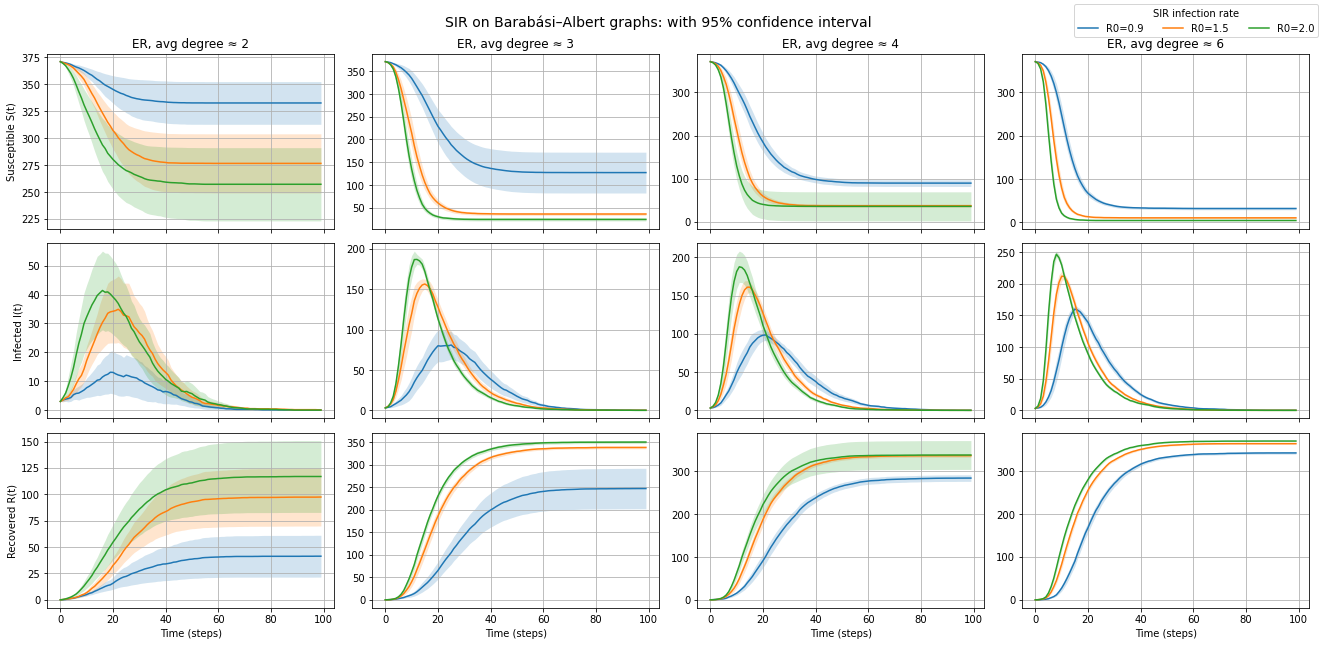

In [15]:

# ----------------------
# Simulation + Plotting
# ----------------------
ncols = len(avg_degrees)
fig, axes = plt.subplots(3, ncols, figsize=(4.6*ncols, 9), sharex=True)
metric_names = ["Susceptible S(t)", "Infected I(t)", "Recovered R(t)"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
t = np.arange(steps)

for col, k in enumerate(avg_degrees):
    # Prepare storage: dict beta -> runs matrix (repetitions x steps)
    S_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    I_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    R_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}

    # For fairness: in each repetition, use one BA graph for all betas
    for r in range(repetitions):
        G = avr_degree_to_BA(N, k)
        for b in betas:
            S, I, R = SIR(G.copy(), b, gamma, fraction_infected, steps)
            S_runs[b][r, :] = S
            I_runs[b][r, :] = I
            R_runs[b][r, :] = R

    # Plot S(t), I(t), R(t) means with ±1σ bands
    axS, axI, axR = axes[0, col], axes[1, col], axes[2, col]

    for i, b in enumerate(betas):
        c = colors[i % len(colors)]

        S_mean, S_std = S_runs[b].mean(axis=0), S_runs[b].std(axis=0)
        I_mean, I_std = I_runs[b].mean(axis=0), I_runs[b].std(axis=0)
        R_mean, R_std = R_runs[b].mean(axis=0), R_runs[b].std(axis=0)

        axS.plot(t, S_mean, color=c, label=f"R0={b/gamma:.1f}")
        axS.fill_between(t, S_mean - 1.96*S_std/np.sqrt(repetitions), S_mean + 1.96*S_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axI.plot(t, I_mean, color=c, label=f"R0={b/gamma:.1f}")
        axI.fill_between(t, I_mean - 1.96*I_std/np.sqrt(repetitions), I_mean + 1.96*I_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axR.plot(t, R_mean, color=c, label=f"R0={b/gamma:.1f}")
        axR.fill_between(t, R_mean - 1.96*R_std/np.sqrt(repetitions), R_mean + 1.96*R_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

    # Titles & axes labels
    axS.set_title(f"ER, avg degree ≈ {k}")
    if col == 0:
        axS.set_ylabel(metric_names[0])
        axI.set_ylabel(metric_names[1])
        axR.set_ylabel(metric_names[2])

    for ax in (axS, axI, axR):
        ax.grid(True)

    axR.set_xlabel("Time (steps)")

# One shared legend (from the top-left axes)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=len(betas), title="SIR infection rate")

fig.suptitle("SIR on Barabási–Albert graphs: with 95% confidence interval", fontsize=14)
plt.tight_layout()
plt.savefig("SIR BA.png")
plt.show()

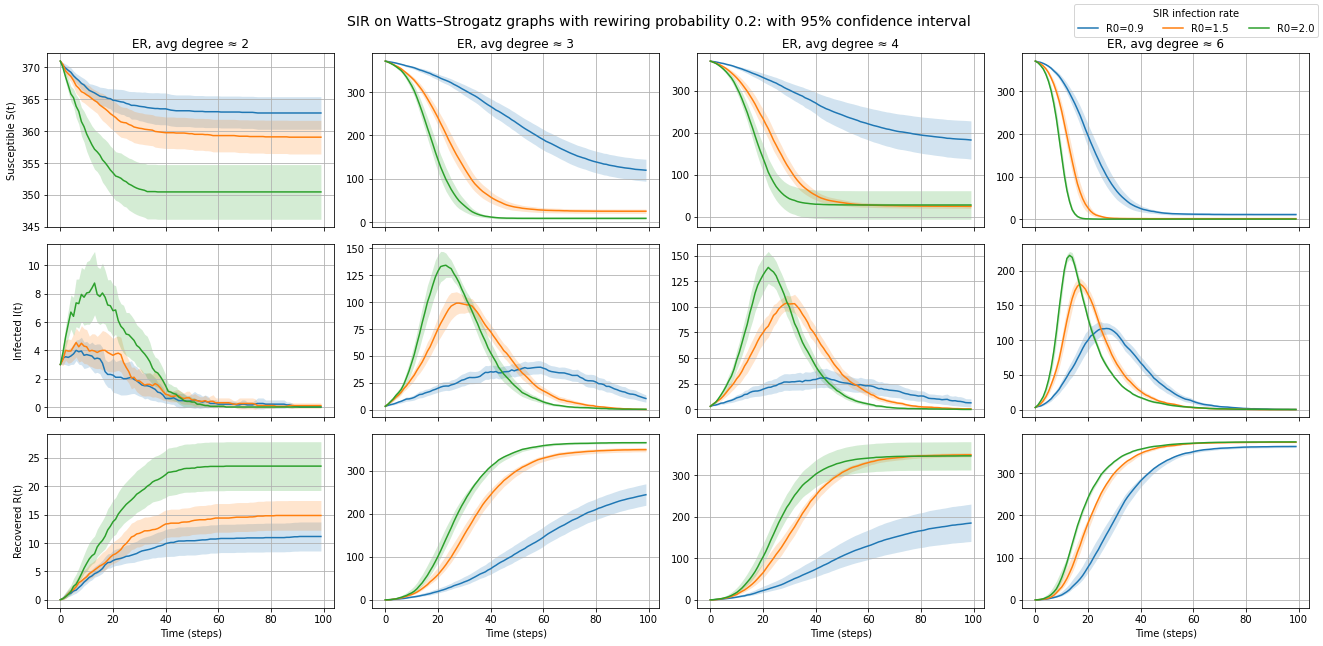

In [16]:


# ----------------------
# Simulation + Plotting
# ----------------------
ncols = len(avg_degrees)
fig, axes = plt.subplots(3, ncols, figsize=(4.6*ncols, 9), sharex=True)
metric_names = ["Susceptible S(t)", "Infected I(t)", "Recovered R(t)"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
t = np.arange(steps)

for col, k in enumerate(avg_degrees):
    # Prepare storage: dict beta -> runs matrix (repetitions x steps)
    S_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    I_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    R_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}

    # For fairness: in each repetition, use one WS graph for all betas
    for r in range(repetitions):
        G = avr_degree_to_WS(N, k, 0.2)
        for b in betas:
            S, I, R = SIR(G.copy(), b, gamma, fraction_infected, steps)
            S_runs[b][r, :] = S
            I_runs[b][r, :] = I
            R_runs[b][r, :] = R

    # Plot S(t), I(t), R(t) means with ±1σ bands
    axS, axI, axR = axes[0, col], axes[1, col], axes[2, col]

    for i, b in enumerate(betas):
        c = colors[i % len(colors)]

        S_mean, S_std = S_runs[b].mean(axis=0), S_runs[b].std(axis=0)
        I_mean, I_std = I_runs[b].mean(axis=0), I_runs[b].std(axis=0)
        R_mean, R_std = R_runs[b].mean(axis=0), R_runs[b].std(axis=0)

        axS.plot(t, S_mean, color=c, label=f"R0={b/gamma:.1f}")
        axS.fill_between(t, S_mean - 1.96*S_std/np.sqrt(repetitions), S_mean + 1.96*S_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axI.plot(t, I_mean, color=c, label=f"R0={b/gamma:.1f}")
        axI.fill_between(t, I_mean - 1.96*I_std/np.sqrt(repetitions), I_mean + 1.96*I_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axR.plot(t, R_mean, color=c, label=f"R0={b/gamma:.1f}")
        axR.fill_between(t, R_mean - 1.96*R_std/np.sqrt(repetitions), R_mean + 1.96*S_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

    # Titles & axes labels
    axS.set_title(f"ER, avg degree ≈ {k}")
    if col == 0:
        axS.set_ylabel(metric_names[0])
        axI.set_ylabel(metric_names[1])
        axR.set_ylabel(metric_names[2])

    for ax in (axS, axI, axR):
        ax.grid(True)

    axR.set_xlabel("Time (steps)")

# One shared legend (from the top-left axes)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=len(betas), title="SIR infection rate")

fig.suptitle("SIR on Watts–Strogatz graphs with rewiring probability 0.2: with 95% confidence interval", fontsize=14)
plt.tight_layout()
plt.savefig("WS_0.2.png")
plt.show()

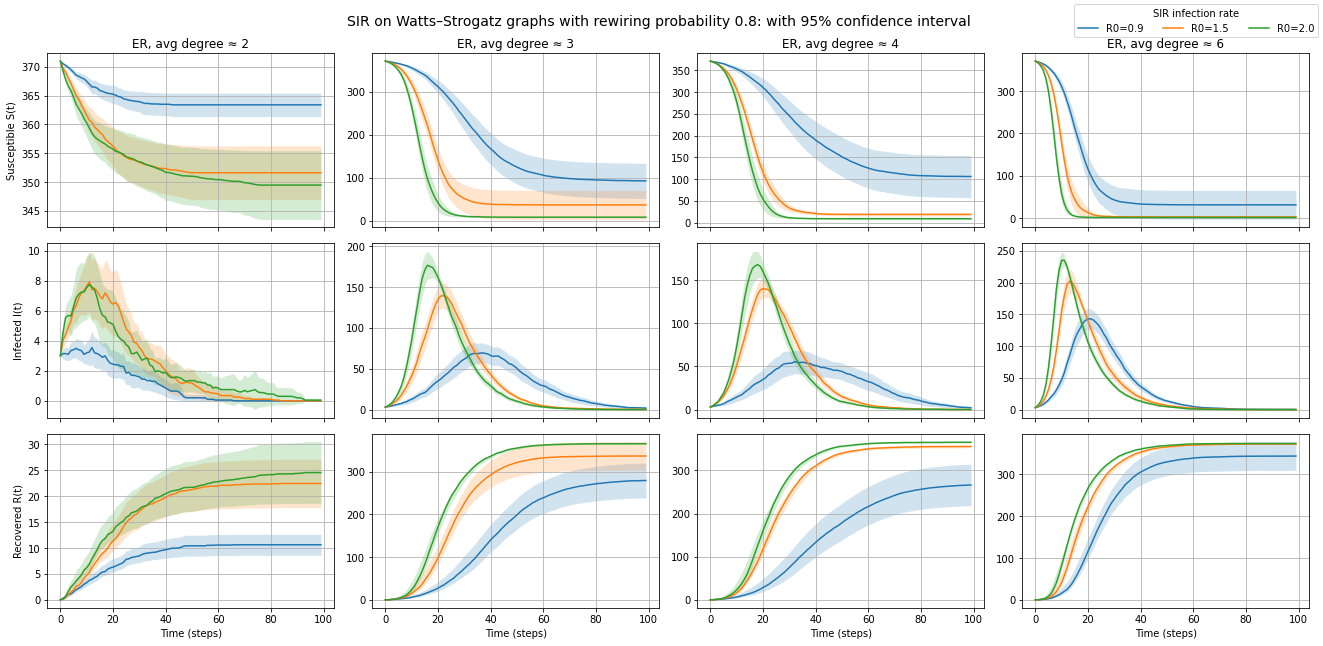

In [17]:
ncols = len(avg_degrees)
fig, axes = plt.subplots(3, ncols, figsize=(4.6*ncols, 9), sharex=True)
metric_names = ["Susceptible S(t)", "Infected I(t)", "Recovered R(t)"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
t = np.arange(steps)

for col, k in enumerate(avg_degrees):
    # Prepare storage: dict beta -> runs matrix (repetitions x steps)
    S_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    I_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}
    R_runs = {b: np.zeros((repetitions, steps), dtype=float) for b in betas}

    # For fairness: in each repetition, use one WS graph for all betas
    for r in range(repetitions):
        G = avr_degree_to_WS(N, k, 0.8)
        for b in betas:
            S, I, R = SIR(G.copy(), b, gamma, fraction_infected, steps)
            S_runs[b][r, :] = S
            I_runs[b][r, :] = I
            R_runs[b][r, :] = R

    # Plot S(t), I(t), R(t) means with ±1σ bands
    axS, axI, axR = axes[0, col], axes[1, col], axes[2, col]

    for i, b in enumerate(betas):
        c = colors[i % len(colors)]

        S_mean, S_std = S_runs[b].mean(axis=0), S_runs[b].std(axis=0)
        I_mean, I_std = I_runs[b].mean(axis=0), I_runs[b].std(axis=0)
        R_mean, R_std = R_runs[b].mean(axis=0), R_runs[b].std(axis=0)

        axS.plot(t, S_mean, color=c, label=f"R0={b/gamma:.1f}")
        axS.fill_between(t, S_mean - 1.96*S_std/np.sqrt(repetitions), S_mean + 1.96*S_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axI.plot(t, I_mean, color=c, label=f"R0={b/gamma:.1f}")
        axI.fill_between(t, I_mean - 1.96*I_std/np.sqrt(repetitions), I_mean + 1.96*I_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

        axR.plot(t, R_mean, color=c, label=f"R0={b/gamma:.1f}")
        axR.fill_between(t, R_mean - 1.96*R_std/np.sqrt(repetitions), R_mean + 1.96*S_std/np.sqrt(repetitions), color=c, alpha=0.2, linewidth=0)

    # Titles & axes labels
    axS.set_title(f"ER, avg degree ≈ {k}")
    if col == 0:
        axS.set_ylabel(metric_names[0])
        axI.set_ylabel(metric_names[1])
        axR.set_ylabel(metric_names[2])

    for ax in (axS, axI, axR):
        ax.grid(True)

    axR.set_xlabel("Time (steps)")

# One shared legend (from the top-left axes)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=len(betas), title="SIR infection rate")

fig.suptitle("SIR on Watts–Strogatz graphs with rewiring probability 0.8: with 95% confidence interval", fontsize=14)
plt.tight_layout()
plt.savefig("WS_0.8.png")
plt.show()

In [199]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("transmission_network.csv", sep=";", index_col=0)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df = df.iloc[:, :]
df.index = df.index.astype(int)
df.columns = df.columns.astype(int)

# Align columns to index order
df = df.loc[df.index, df.index]
G = nx.from_pandas_adjacency(df)
G = nx.convert_node_labels_to_integers(G)
print(G.nodes())

#Print some information about the graph
print(G)
tot_degree = 0
for n in G.nodes():
    tot_degree+= G.degree(n)
print("Average degree of G is: ",end=" ")
print(tot_degree/len(G.nodes()))
print("Average clustering coefficent of G is: ",end=" ")
print(nx.average_clustering(G))
print("The average shortest path lengths for each subgraph are: ",end=" ")
for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
    print(nx.average_shortest_path_length(C), end=" ")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

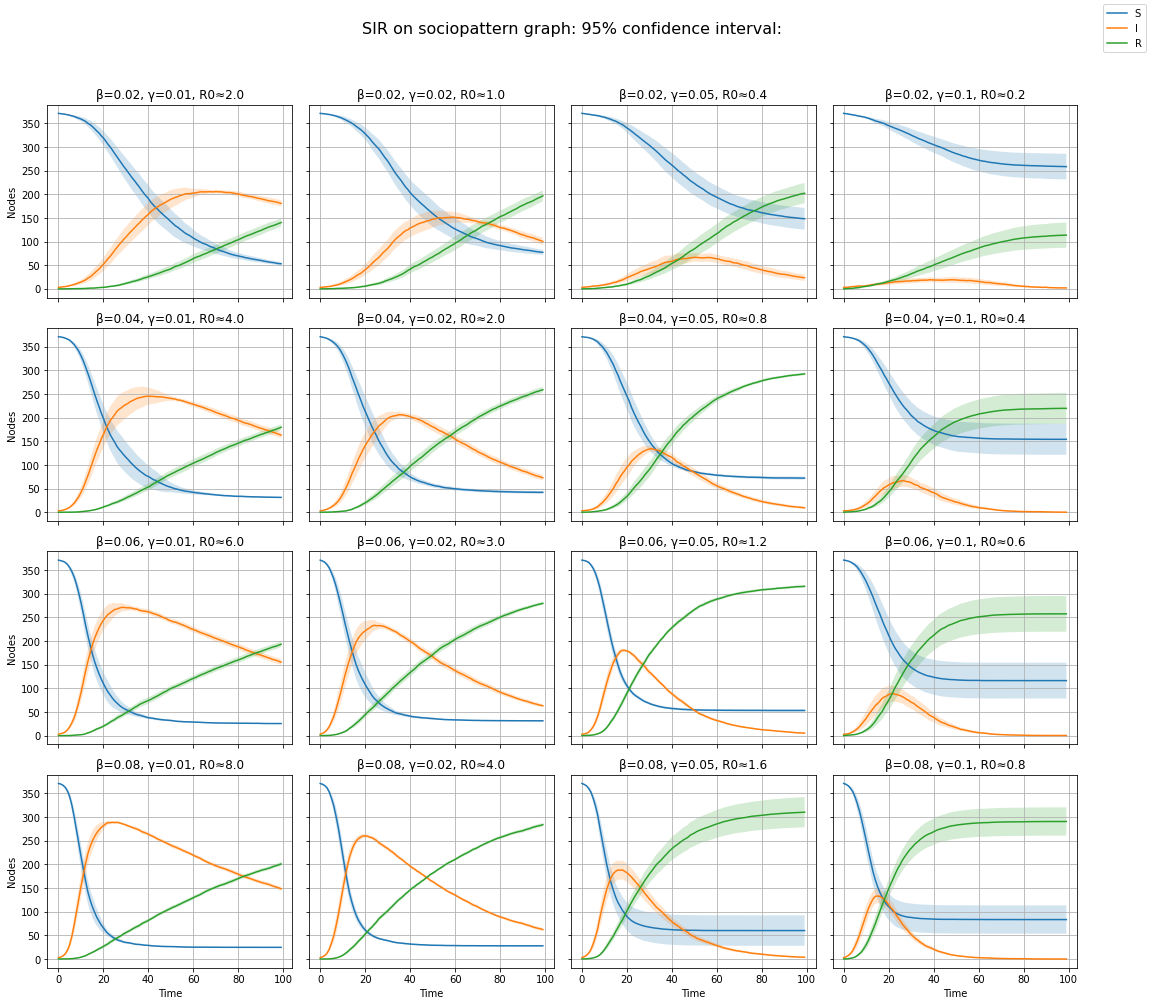

In [188]:
betas = [0.02, 0.04, 0.06, 0.08]     # 4 beta values
gammas = [0.01, 0.02, 0.05, 0.1]     # 4 gamma values
fraction_infected = 0.01
repetitions = 20
steps = 100

t = np.arange(steps)

def run_mean_ci(G, beta, gamma):
    S_runs = np.zeros((repetitions, steps))
    I_runs = np.zeros((repetitions, steps))
    R_runs = np.zeros((repetitions, steps))

    for r in range(repetitions):
        S, I, R = SIR(G.copy(), beta, gamma, fraction_infected, steps)
        S_runs[r], I_runs[r], R_runs[r] = S, I, R

    def stats(arr):
        mean = arr.mean(axis=0)
        std = arr.std(axis=0, ddof=1)
        ci = 1.96 * std / np.sqrt(repetitions)
        return mean, ci

    return stats(S_runs), stats(I_runs), stats(R_runs)

# FIGURE GRID: rows = betas, columns = gammas
fig, axes = plt.subplots(len(betas), len(gammas),
                         figsize=(4*len(gammas), 3.5*len(betas)),
                         sharex=True, sharey=True)

if len(betas) == 1 and len(gammas) == 1:
    axes = np.array([[axes]])

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        (S_mean, S_ci), (I_mean, I_ci), (R_mean, R_ci) = run_mean_ci(G, beta, gamma)
        ax = axes[i, j]

        ax.plot(t, S_mean, label="S")
        ax.fill_between(t, S_mean - S_ci, S_mean + S_ci, alpha=0.2)

        ax.plot(t, I_mean, label="I")
        ax.fill_between(t, I_mean - I_ci, I_mean + I_ci, alpha=0.2)

        ax.plot(t, R_mean, label="R")
        ax.fill_between(t, R_mean - R_ci, R_mean + R_ci, alpha=0.2)

        ax.set_title(f"β={beta}, γ={gamma}, R0≈{beta/gamma:.1f}")
        ax.grid(True)

        if i == len(betas)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Nodes")

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

fig.suptitle("SIR on sociopattern graph: 95% confidence interval:", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.savefig("SIR_socio.png")
plt.show()


In [19]:
def plot_SIR(S, I, R, title="SIR Model Simulation"):
    time_steps = range(len(S))

    plt.figure(figsize=(8, 5))

    plt.plot(time_steps, S, label='Susceptible', linewidth=2)
    plt.plot(time_steps, I, label='Infected', linewidth=2)
    plt.plot(time_steps, R, label='Recovered', linewidth=2)

    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Number of Individuals', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
"""
Function that returns the four SIR simulation on a given graph G with four
different vaccination statergies.
1. No vaccinations
2. Random vaccinations
3. Targeted vaccinations (highest degree nodes)
4. Testing-based vaccinations (as described in the paper)

INPUT:
G: networkx graph
initial_infected: list of initially infected nodes
initial_recovered: list of initially recovered nodes
time_steps: number of time steps to simulate
beta: infection rate
gamma: recovery rate
vacc_budget: number of vaccinations available per time step
test_budget: number of tests available per time step
test_accuracy: accuracy of the tests (probability of correct result)

OUTPUT:
S: list of four lists, each containing the susceptible count over time
I: list of four lists, each containing the infected count over time
R: list of four lists, each containing the recovered count over time
"""

def SIR_four_vaccination_strat(G, initial_infected, initial_recovered, time_steps, beta, gamma, vacc_budget,
                             test_budget, test_accuracy):

    N = G.number_of_nodes()
    S = [0] * time_steps # Susceptible count over time
    I = [0] * time_steps# Infected count over time
    R = [0] * time_steps# Recovered count over time

    # Lists to keep track of susceptible, infected, recovered and vaccinated nodes
    susceptible = [True] * N
    infected = [False] * N
    recovered = [False] * N
    vaccinated = [False] * N


    # Setup intial conditions
    S[0] = N-len(initial_infected)-len(initial_recovered)
    I[0] = len(initial_infected)
    R[0] = len(initial_recovered)

    # Set intial infected and recovered nodes
    for node in initial_infected:
        susceptible[node] = False
        infected[node] = True
    for node in initial_recovered:
        susceptible[node] = False
        recovered[node] = True

    #Copy setup for all four strategies
    S = [S.copy() for _ in range(4)]
    I = [I.copy() for _ in range(4)]
    R = [R.copy() for _ in range(4)]

    susceptible = [susceptible.copy() for _ in range(4)]
    infected = [infected.copy() for _ in range(4)]
    recovered = [recovered.copy() for _ in range(4)]
    vaccinated = [vaccinated.copy() for _ in range(4)]

    # Test a single node for infection
    def test(s, node):
        true_result = infected[s][node]
        if np.random.rand() < test_accuracy:
            return true_result
        else:
            return not true_result

    # Vaccinate a single node on time t
    def vaccinate(s, node, t):
        if not vaccinated[s][node]:
            vaccinated[s][node] = True
            if susceptible[s][node] and not infected[s][node]:
                susceptible[s][node] = False
                recovered[s][node] = True
                S[s][t] -= 1
                R[s][t] += 1
        return

    degree_pairs = [(n, G.degree(n)) for n in range(N)]
    degree_pairs.sort(key=lambda x: x[1], reverse=True)
    degree_order = [n for n, _ in degree_pairs]

    # Simulation loop
    for t in range(1, time_steps):
        for k in range(4):
            S[k][t] = S[k][t-1]
            I[k][t] = I[k][t-1]
            R[k][t] = R[k][t-1]
            new_infected = []
            new_recovered = []
            sus = susceptible[k]
            inf = infected[k]
            rec = recovered[k]
            vac = vaccinated[k]

            # Loop over all nodes
            for i in range(N):

                # If node is recovered skip
                if rec[i]:
                    continue

                # If node is susceptible check for infection
                if sus[i]:
                    # check all neighbors if they infect our node
                    for j in G.neighbors(i):
                        if inf[j]:
                            if np.random.rand() < beta:
                                new_infected.append(i)
                                break

                # If node is infected check for recovery
                else:
                    if np.random.rand() < gamma:
                        new_recovered.append(i)

            # Vaccination step depends on strategy
            
            # Strategy 1: No vaccinations
            if k==0:
                pass

            # Strategy 2: Random vaccination
            elif k==1:
                candidates = [n for n in range(N) if not vac[n] and sus[n]]
                if candidates:
                    nmbr_to_vacc = min(vacc_budget, len(candidates))
                    for n in np.random.choice(candidates, nmbr_to_vacc, replace=False):
                        vaccinate(k, n, t)

            # Strategy 3: Targeted vaccination (highest degree)
            elif k==2:
                test_left = test_budget
                vacc_left = vacc_budget
                for node in degree_order:
                    if vacc_left <=0:
                        break
                    if not vac[node]:
                        if test_left >0:
                            test_left -= 1
                            if test(k, node):
                                continue
                        vaccinate(k, node, t)
                        vacc_left -= 1
            elif k==3:


            #Count number of vaccinations and tests
                vacc_left = vacc_budget
                test_left = test_budget

                """
                Tests random non vaccinated nodes to find an infected individual,
                else returns the first non vaccinated nodes index. If all nodes are
                vaccinated returns -1.
                """
                def find_infected_node():
                    nonlocal test_left
                    nonlocal k
                    if all(vac):
                        return -1
                    while test_left > 0:
                        node = np.random.randint(0, N)
                        if vac[node]:
                            continue
                        test_left -= 1
                        if test(k, node):
                            return node
                    for n in range(N):
                        if not vac[n]:
                            return n
                    return -1

                start_node = find_infected_node()

                # If all nodes are vaccinated skip vaccination
                if start_node != -1:

                    #Start vaccinatting all suseptible and non infected neighbors
                    queue = [start_node]
                    visited = [False] * N

                    # Start vaccinating neighbors of infected individuals
                    while vacc_left>0:
                        #If we can't test anymore we just vaccinate
                        if test_left <=0:
                            # First vaccinate everyone in the queue
                            for n in queue:
                                if not vac[n]:
                                    if vacc_left <=0:
                                        break
                                    vaccinate(k, n, t)
                                    vacc_left -= 1
                            # Vaccinate random individuals until out of vaccines
                            candidates = [n for n in range(N) if not vac[n]]
                            while vacc_left > 0:
                                if candidates == []:
                                    break
                                n = candidates.pop()
                                vaccinate(k, n, t)
                                vacc_left -= 1
                            break
                        # If ever no neighbors to test, start from a random node
                        # because we always want to use up our vacinations and tests
                        if queue == []:
                            new_start = find_infected_node()

                            #All nodes are vacinated
                            if new_start == -1:
                                break
                            queue.append(new_start)
                            continue
                        # BFS to explore neighbors
                        current = queue.pop(0)
                        if visited[current]:
                            continue
                        visited[current] = True

                        # Skip if already vaccinated
                        if vac[current]:
                            continue
                        test_left -= 1
                        # We are looking at an infected node,
                        # so we test all neighbors
                        if test(k, current):
                            # Add all non visited and non vaccinated neighbors of a sick
                            # node to the queue
                            for neighbor in G.neighbors(current):
                                if not visited[neighbor] and not vac[neighbor]:
                                    queue.append(neighbor)

                        # Else we vaccinate the individual
                        else:
                            vaccinate(k, current, t)
                            vacc_left -= 1
            for node in new_infected:
                if vac[node]:
                    continue
                sus[node] = False
                inf[node] = True
                S[k][t] -= 1
                I[k][t] += 1
            for node in new_recovered:
                if inf[node]:
                    inf[node] = False
                    rec[node] = True
                    I[k][t] -= 1
                    R[k][t] += 1
        # S[t] -= len(new_infected)
        # I[t] += len(new_infected) - len(new_recovered)
        # R[t] += len(new_recovered)
    return S, I, R

Graph with 374 nodes and 1122 edges


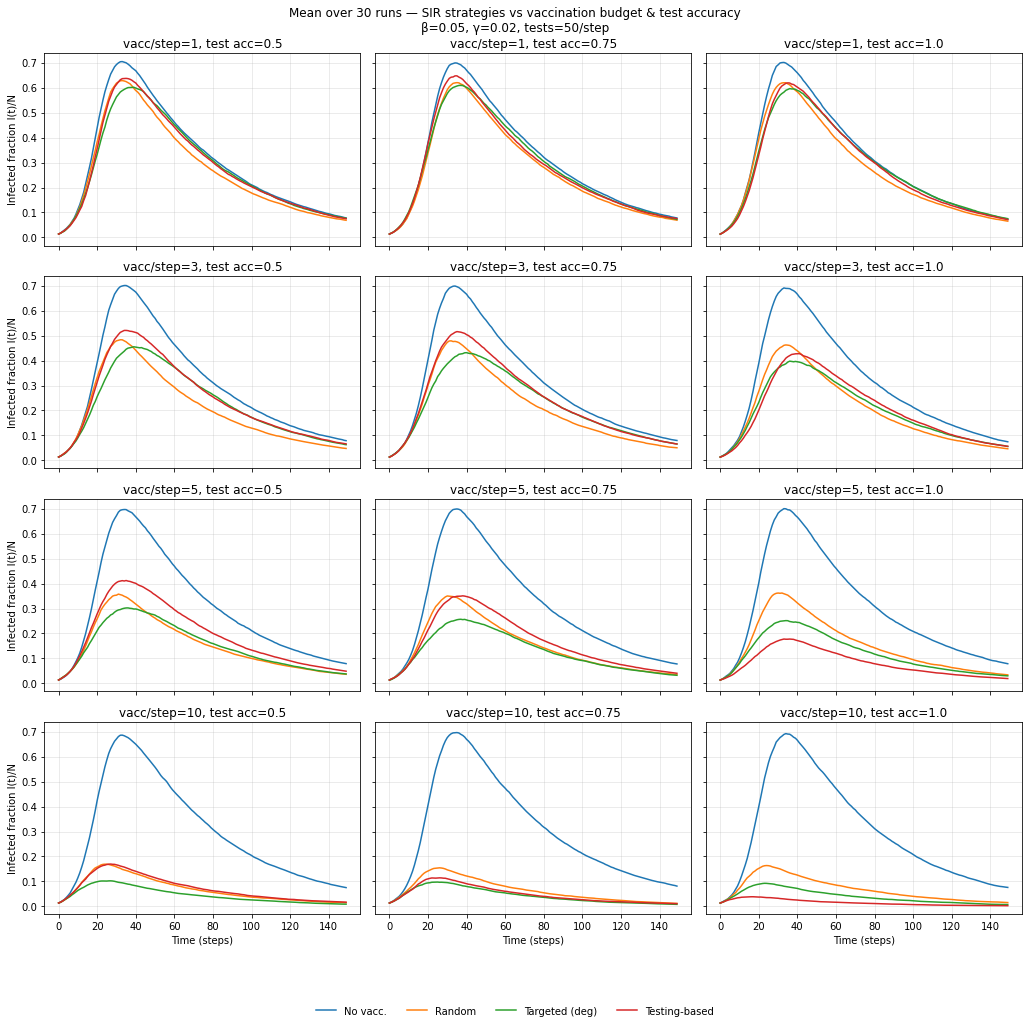

In [20]:
vacc_budgets    = [1, 3, 5, 10]         # rows
test_accuracies = [0.5, 0.75, 1.0]      # cols
repetitions = 30

time_steps = 150
beta, gamma = 0.05, 0.02
test_budget = 50

print(G)

strategy_names = [
    "No vacc.",
    "Random",
    "Targeted (deg)",
    "Testing-based"
]

def run_mean_curves(vb, acc):
    # Initialize accumulators
    S_sum = [np.zeros(time_steps) for _ in range(4)]
    I_sum = [np.zeros(time_steps) for _ in range(4)]
    R_sum = [np.zeros(time_steps) for _ in range(4)]

    for _ in range(repetitions):
        rng = np.random.default_rng()
        initial_infected  = list(rng.choice(G.number_of_nodes()-1, size=5, replace=False))
        initial_recovered = []

        S, I, R = SIR_four_vaccination_strat(
            G,
            initial_infected,
            initial_recovered,
            time_steps,
            beta,
            gamma,
            vb,
            test_budget,
            acc
        )

        for s_idx in range(4):
            S_sum[s_idx] += np.array(S[s_idx])
            I_sum[s_idx] += np.array(I[s_idx])
            R_sum[s_idx] += np.array(R[s_idx])

    return ([x / repetitions for x in S_sum],
            [x / repetitions for x in I_sum],
            [x / repetitions for x in R_sum])

# --------- run all conditions ----------
results = {}
for vb in vacc_budgets:
    for acc in test_accuracies:
        results[(vb, acc)] = run_mean_curves(vb, acc)

# --------- plot ----------
t = np.arange(time_steps)
fig, axes = plt.subplots(len(vacc_budgets), len(test_accuracies),
                         figsize=(4.8*len(test_accuracies), 3.4*len(vacc_budgets)),
                         sharex=True, sharey=True)

if axes.ndim == 1:
    axes = axes.reshape(len(vacc_budgets), len(test_accuracies))

for r, vb in enumerate(vacc_budgets):
    for c, acc in enumerate(test_accuracies):
        ax = axes[r, c]
        S_mean, I_mean, R_mean = results[(vb, acc)]
        for s_idx, name in enumerate(strategy_names):
            ax.plot(t, I_mean[s_idx] / N, label=name)
        ax.set_title(f"vacc/step={vb}, test acc={acc}")
        if c == 0: ax.set_ylabel("Infected fraction I(t)/N")
        if r == len(vacc_budgets) - 1: ax.set_xlabel("Time (steps)")
        ax.grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="lower center", bbox_to_anchor=(0.5, -0.02), ncol=4, frameon=False)

# Reserve bottom margin for legend
plt.tight_layout(rect=[0, 0.05, 1, 1])

fig.suptitle(f"Mean over {repetitions} runs — SIR strategies vs vaccination budget & test accuracy\n"
             f"β={beta}, γ={gamma}, tests={test_budget}/step", y=1.02)
plt.savefig("Vaccination_strategies.png")